In [ ]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import numpy as np

# Overview of my solution

I analyze Apple (AAPL) stock over its entire lifetime.

### Model Used: 
- Kth Nearest Neighbors

### Inputs:
- Moving Average (with various windows)
- Exponential Moving Average (with various windows)

### Outputs:
- 1 if 'Close Adj' moves up compared to the previous day
- 0 if 'Close Adj' stays the same compared to the previous day
- -1 if 'Close Adj' moves down compared to the previous day

### Results:
Predicted correctly 56.84% of the time.

# Problem 1
Download Apple (AAPL) historical stock data from Yahoo Finance. 

In [3]:
data = yf.download('AAPL')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092492,73449600
...,...,...,...,...,...,...
2022-12-14,145.350006,146.660004,141.160004,143.210007,143.210007,82291200
2022-12-15,141.110001,141.800003,136.029999,136.500000,136.500000,98931900
2022-12-16,136.690002,137.649994,133.729996,134.509995,134.509995,160080100


# Problem 2
Plot one of the field w.r.t. time

In [4]:
data.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Text(0, 0.5, 'Adj Close ($)')

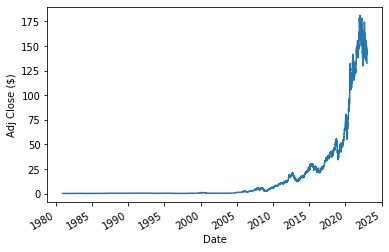

In [5]:
close = data['Adj Close']
close.plot()
plt.ylabel('Adj Close ($)')

# Problem 3
Preprocess the data. 

I'll be training the model on moving averages (MA) and exponential moving averages (EMA) of various windows. We know stocks can be modeled by stochastic differential equations, and thus have an inherent "noise" factor to them. So MA and EMA should help cut down on that.

I'll be using this to predict wether the stock will move up or down. I won't know by how much. The outputs will be
- 1: moves up
- 0: stays the same
- -1: moves down

In [6]:
def find_percent_change(values):
    """
    Input:
    * values (list of floats) - time series data for prices

    Output:
    * percent_changes (list of floats) - time series data for percent change between days
                                         The first entry will be 'np.nan'
    """

    # Initialize a list to store the percent changes
    percent_changes = [np.nan]

    # Iterate over the elements in the list, starting from the second element
    for i in range(1, len(values)):
        # Calculate the percent change between the current element and the previous element
        percent_change = (values[i] - values[i-1]) / values[i-1] * 100
        # Append the percent change to the list
        percent_changes.append(percent_change)
    
    return percent_changes

def sign_function(values):
  signs = []
  for i in values:
    if i > 0:
      signs.append(1)
    elif i == 0:
      signs.append(0)
    else:
      signs.append(-1)
  return signs

def moving_average(data, window_size):
    moving_averages = [np.nan for _ in range(window_size - 1)]
    for i in range(len(data) - window_size + 1):
        window = data[i:i+window_size]
        moving_averages.append(sum(window) / len(window))
    return moving_averages

def exponential_moving_average(data, window_size):
    exponential_moving_averages = [np.nan for _ in range(window_size - 1)]
    for i in range(len(data)):
        if i < window_size - 1:
            exponential_moving_averages.append(None)
        else:
            ema_prev = exponential_moving_averages[-1] if exponential_moving_averages else data[0]
            k = 2 / (window_size + 1)
            ema = data[i] * k + ema_prev * (1 - k)
            exponential_moving_averages.append(ema)
    return exponential_moving_averages


In [7]:
pc_list = find_percent_change(close.values)

iterations = np.array([1,2,3,4,5,6,7,8,9,10])
for i in iterations:
  ma_list = moving_average(close.values, i)
  ema_list = moving_average(close.values, i)
  data[f'Adj Closing MA {i}'] = ma_list
  data[f'Adj Closing EMA {i}'] = ema_list
data[f'Adj Closing PC'] = pc_list
data['Direction of Movement'] = sign_function(pc_list)

print("Summed percent change over all time is", data['Adj Closing PC'].sum(), "%")
data

Summed percent change over all time is 1150.2442295671829 %


,Open,High,Low,Close,Adj Close,Volume,Adj Closing MA 1,Adj Closing EMA 1,Adj Closing MA 2,Adj Closing EMA 2,...,Adj Closing MA 7,Adj Closing EMA 7,Adj Closing MA 8,Adj Closing EMA 8,Adj Closing MA 9,Adj Closing EMA 9,Adj Closing MA 10,Adj Closing EMA 10,Adj Closing PC,Direction of Movement
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600,0.099874,0.099874,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800,0.094663,0.094663,0.097269,0.097269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.217072,-1
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000,0.087715,0.087715,0.091189,0.091189,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.339792,-1
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600,0.089886,0.089886,0.088801,0.088801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.475083,1
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092492,73449600,0.092492,0.092492,0.091189,0.091189,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.899250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,145.350006,146.660004,141.160004,143.210007,143.210007,82291200,143.210007,143.210007,144.340004,144.340004,...,143.118574,143.118574,143.557503,143.557503,144.030002,144.030002,144.458002,144.458002,-1.553581,-1
2022-12-15,141.110001,141.800003,136.029999,136.500000,136.500000,98931900,136.500000,136.500000,139.855003,139.855003,...,142.202859,142.202859,142.291252,142.291252,142.773336,142.773336,143.277002,143.277002,-4.685431,-1
2022-12-16,136.690002,137.649994,133.729996,134.509995,134.509995,160080100,134.509995,134.509995,135.504997,135.504997,...,141.284286,141.284286,141.241251,141.241251,141.426668,141.426668,141.947002,141.947002,-1.457879,-1


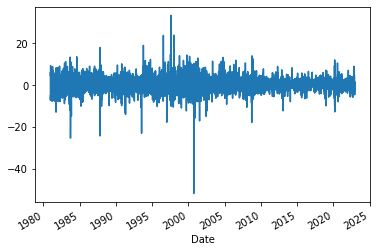

In [8]:
data['Adj Closing PC'].plot()

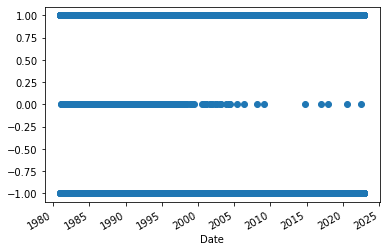

In [9]:
data['Direction of Movement'].plot(style='o')

(738392.0, 738509.0)

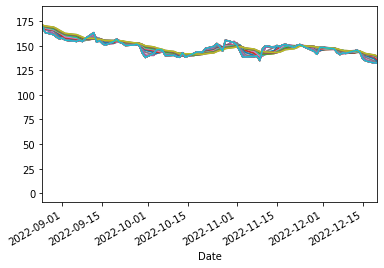

In [10]:
for i in iterations:
  data[f'Adj Closing MA {i}'].plot()
  data[f'Adj Closing EMA {i}'].plot()
  data[f'Adj Close'].plot()

plt.xlim(["2022-08-25","2022-12-20"])

# Problem 4
Train ML.

I chose K'th Neaest Neighbors because I wanted to see how it could group the categories 1,0,-1 dependening the distribution of the EMA and MA (which forms a scatter plot in higher dimensions).

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_data = []
for t in range(len(data.index)):
  parameters_at_t = []
  for i in iterations:
    parameters_at_t.append(data[f'Adj Closing MA {i}'].values[t])
    parameters_at_t.append(data[f'Adj Closing EMA {i}'].values[t])
  x_data.append(parameters_at_t)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, data['Direction of Movement'], test_size=0.2, random_state=0, shuffle=False)

x_train_df = pd.DataFrame(x_train, index=y_train.index)
x_train_df = x_train_df.drop(x_train_df.index[:iterations[-1] - 1])
y_train    = y_train.iloc[iterations[-1] - 1:]

print("number of parameters we're training on is: ", len(x_train[0]))

number of parameters we're training on is:  20


In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Create the model
model = KNeighborsClassifier(n_neighbors=len(x_train[0])) # I chose this so we're matching the neighbors to amount of parameters we're sweeping

# Fit the model to the data
model.fit(x_train_df, y_train)

# Predict based on given test data
y_pred = model.predict(x_test)

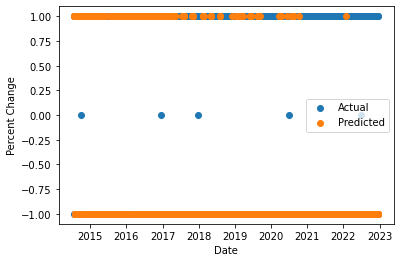

In [16]:
# Let's see the results visually

plt.scatter(y_test.index, y_test, label='Actual')
plt.scatter(y_test.index, y_pred, label="Predicted")
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()

Amount of directions we got CORRECT = 1205
Amount of directions we got WRONG = 915
Percent we got correct = 56.839622641509436%
We're winning!


Text(0, 0.5, 'Amount of times correct')

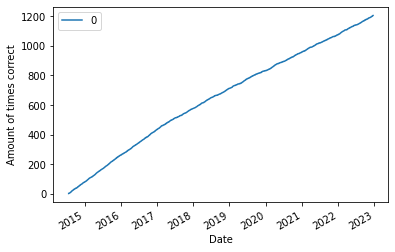

In [17]:
# Now I want to see how many times I was correct
when_correct = [0]
amount_correct = 0
amount_wrong = 0
for t,p in zip(y_test, y_pred):
  if (t == p):
    when_correct.append(when_correct[-1] + 1)
    amount_correct += 1
  else:
    when_correct.append(when_correct[-1])
    amount_wrong += 1
when_correct.pop(0)

percent_correct = amount_correct / (amount_correct + amount_wrong) * 100

print(f'Amount of directions we got CORRECT = {amount_correct}')
print(f'Amount of directions we got WRONG = {amount_wrong}')
print(f'Percent we got correct = {percent_correct}%')

if percent_correct > 50:
  print("We're winning!")



when_correct_df = pd.DataFrame(when_correct, index = y_test.index)
when_correct_df.plot()
plt.ylabel('Amount of times correct')




## Wow! This strategy can predict wether a stock will move up or down above 50%! Not bad.